# Chapter 2 Time series graphics

In [ ]:
%load_ext autoreload
%autoreload 2

In [82]:
import pandas as pd

## 2.1 Date Manipulation
It's possible to use the `parse_dates` argument in reading a csv file to convert specified columns to Pandas dates.

In [83]:
olympic_running = pd.read_csv('data/tsibbledata/olympic_running.csv', parse_dates=['Year'])
olympic_running.dtypes

Year      datetime64[ns]
Length             int64
Sex               object
Time             float64
dtype: object

In the following example, the date format for 'Month' is non-standard, in which case we should convert it using the `pd.to_datetime` method instead of parsing it while reading. The correct format is `%Y %b`. 

In [256]:
PBS = pd.read_csv('data/tsibbledata/PBS.csv')
PBS.head()

,Month,Concession,Type,ATC1,ATC1_desc,ATC2,ATC2_desc,Scripts,Cost
0,1991 Jul,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,18228,67877.0
1,1991 Aug,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15327,57011.0
2,1991 Sep,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14775,55020.0
3,1991 Oct,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15380,57222.0
4,1991 Nov,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14371,52120.0


In [257]:
PBS['Date'] = pd.to_datetime(PBS['Month'], format='%Y %b')


We can translate the following R code to Python using Pandas. Chaining the operations without creating intermediate DataFrames helps to reduce memory usage and improve performance.
```R
PBS |>
  filter(ATC2 == "A10") |>
  select(Month, Concession, Type, Cost) |>
  summarise(TotalC = sum(Cost)) |>
  mutate(Cost = TotalC / 1e6) -> a10
```

In [86]:
a10 = (
    PBS.query('ATC2 == "A10"')  # Filter rows where ATC2 is "A10"
    .groupby('Month', as_index=False)  # Group by Month
    .agg({'Cost': 'sum'})  # Summarize total cost by month
    .assign(Cost=lambda df: df['Cost'] / 1e6)  # Convert cost to millions
)

## 2.2 Time Plots
We use the Python library `plotnine`, which is the Python port of `ggplot2` to generate our plots.

In [ ]:
from plotnine import ggplot, aes, geom_line, labs
from plotnine import scale_x_datetime
from plotnine import scale_x_continuous, geom_text, theme, scale_color_discrete
from mizani.formatters import date_format

In [147]:
# Define a custom date parser function
def parse_week_date(date_str):
    year, week = date_str.split(' W')
    return pd.to_datetime(f'{year}-W{week}-1', format='%Y-W%W-%w') #+ pd.Timedelta(days=6)
ansett = pd.read_csv('data/tsibbledata/ansett.csv')
ansett['Date'] = ansett['Week'].apply(parse_week_date)

In [148]:
melsyd_economy = (ansett
    .query('Airports == "MEL-SYD" and Class == "Economy"')
    .assign(Passengers=lambda df: df['Passengers']/1000.)
)

### Ansett airlines economy class from Melbourne to Sydney
There was a period in 1989 when no passengers were carried — this was due to an industrial dispute.
There was a period of reduced load in 1992. This was due to a trial in which some economy class seats were replaced by business class seats.
A large increase in passenger load occurred in the second half of 1991.
There are some large dips in load around the start of each year. These are due to holiday effects.
There is a long-term fluctuation in the level of the series which increases during 1987, decreases in 1989, and increases again through 1990 and 1991.
Any model will need to take all these features into account in order to effectively forecast the passenger load into the future.

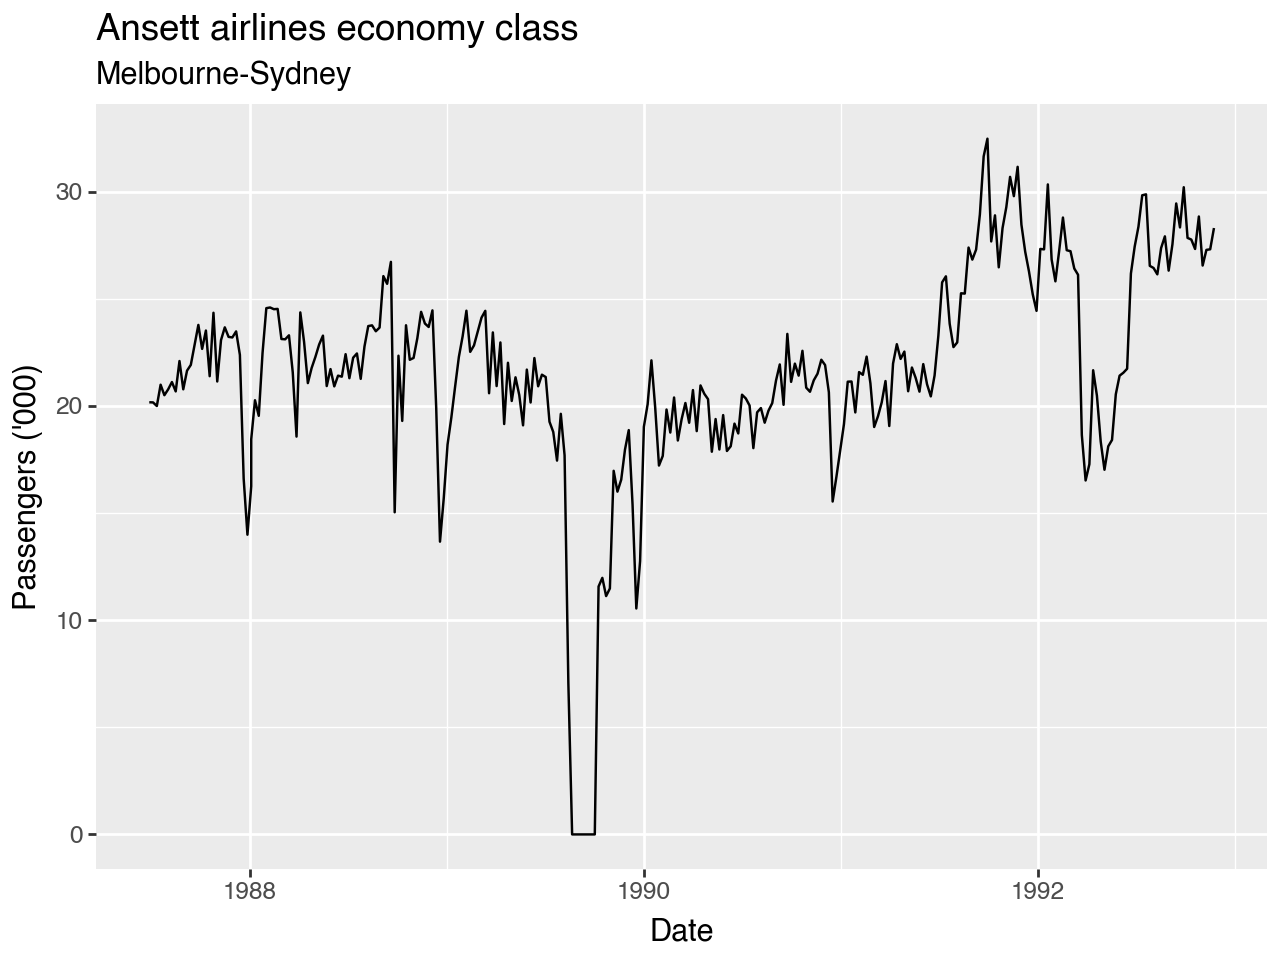

In [151]:
ggplot(melsyd_economy) \
+ aes(x='Date', y="Passengers") \
+ geom_line() \
+ scale_x_datetime(labels=date_format('%Y'))\
+ labs(title = "Ansett airlines economy class",
       subtitle = "Melbourne-Sydney",
       y = "Passengers ('000)")

### Australian antidiabetic drug sales
We see a clear and increasing trend, with strong seasonal pattern that increases in size as the level of the series increases. The sudden drop at the start of each year is caused by a government subsidisation scheme that makes it cost-effective for patients to stockpile drugs at the end of the calendar year. Any forecasts of this series would need to capture the seasonal pattern, and the fact that the trend is changing slowly.

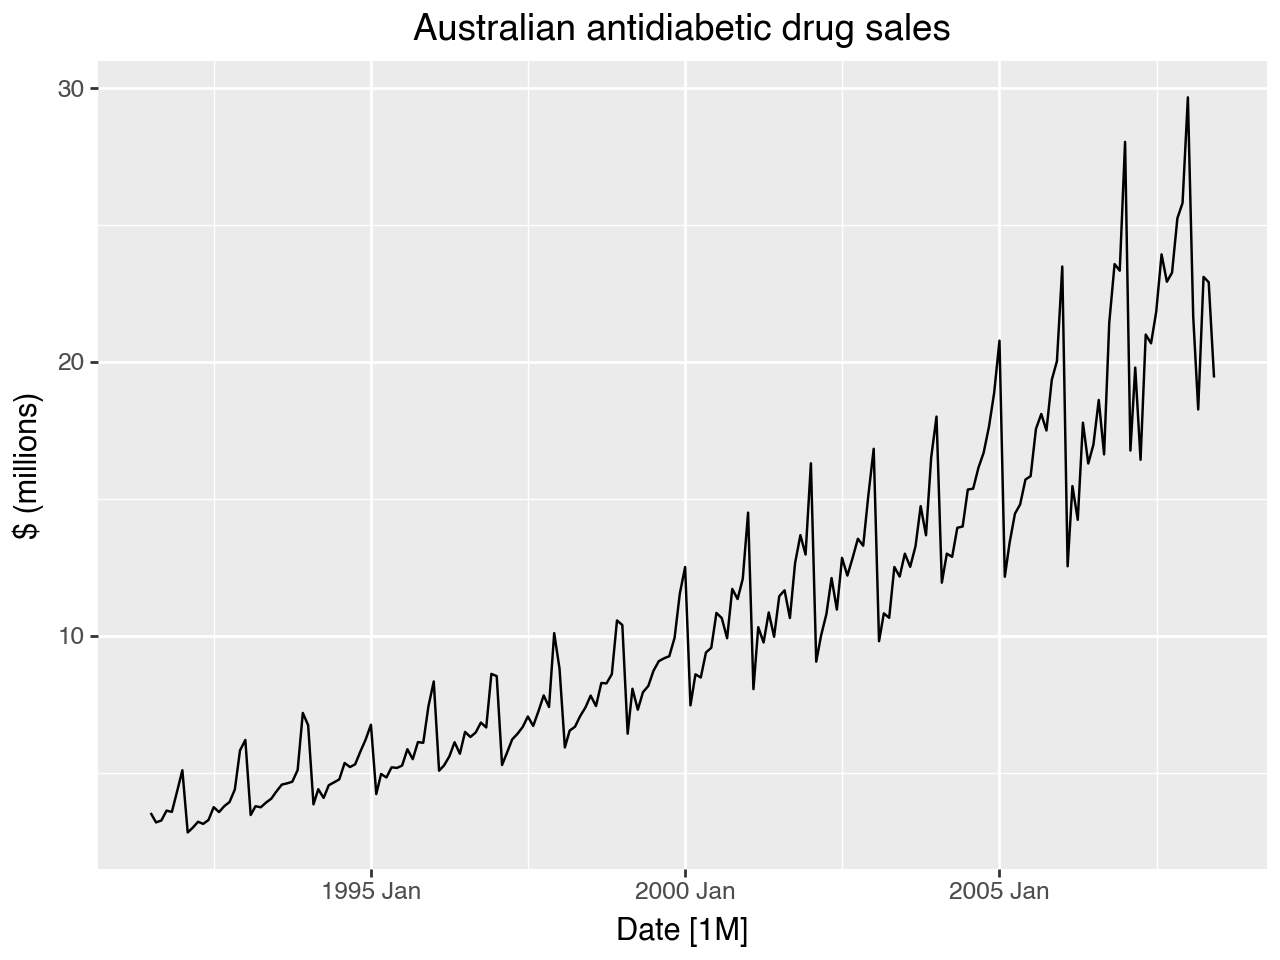

In [159]:
ggplot(a10) + aes('Month', 'Cost') + geom_line() \
    + scale_x_datetime(labels=date_format('%Y %b')) \
    + labs(y = "$ (millions)",
        x = 'Date [1M]',
       title = "Australian antidiabetic drug sales")
